In [1]:
# ====================================================
# CFG
# ====================================================
import numpy as np
class CFG:
    wandb = False
    DEBUG = False
    TO_KAGGLE = False
    score_path = "gs://feedback3/output/scores/scores3.csv"
    MEMO = "ベースライン"
    file_name = "002"
    model="bert/large-uncased"
    patience = 3
    n_fold=4
    trn_fold=[0,1,2,3]
    model_config_path = f"/home/jupyter/models/{model}/"
    model_bin_path = f"/home/jupyter/models/{model}/"
    competition='FB3'
    apex=True
    print_freq=20
    num_workers=4
    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=10
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    seed=42
    train=True
    
if CFG.DEBUG:
    CFG.epochs = 2
    #CFG.trn_fold = [0]

In [2]:
import os
import datetime
import pickle
import glob

# ====================================================
# datetime
# ====================================================
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
date = now.strftime('%Y%m%d')
date2 = now.strftime('%Y%m%d%H%M')


# ====================================================
# file_path
# ====================================================
if "/" in CFG.model:
    model_name = CFG.model.replace("/","-")
else:
    model_name = CFG.model

path ="/home/jupyter/feedback-prize-english-language-learning/"
if CFG.DEBUG:
    OUTPUT_DIR = f'/home/jupyter/output/ex/DEBUG/{model_name}/{CFG.file_name}/{date2}/'
else:
    OUTPUT_DIR = f'/home/jupyter/output/ex/{model_name}/{CFG.file_name}/{date2}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)



# ====================================================
# wandb 
# ====================================================
if CFG.wandb:
    import wandb
    
    def class2dict(f):
            return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
        
    project='Feedback Prize - English Language Learning'
    if CFG.DEBUG:
        group = "DEBUG"
    else:
        group = model_name
    wandb_name = f"{CFG.file_name}_{date2}"
    job_type = CFG.file_name  #"train"

    wandb_api = "your_id"
    wandb.login(key=wandb_api)
    anony = None
    run = wandb.init(project=project, 
                         name = wandb_name,
                         config=class2dict(CFG),
                         group=group,
                         job_type=job_type,
                         anonymous=anony)

# Library

In [3]:
import numpy as np 
import pandas as pd 
import os, gc, re, warnings
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

warnings.filterwarnings("ignore")

from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [5]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"full_text"]
        tokens = tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=MAX_LEN,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

def get_embeddings(MODEL_NM='', MAX=512, BATCH_SIZE=4, verbose=True):
    global tokenizer, MAX_LEN
    DEVICE="cuda"
    model = AutoModel.from_pretrained( MODEL_NM )
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )
    MAX_LEN = MAX
    
    model = model.to(DEVICE)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
        all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)
    if verbose:
        print('Train embeddings shape',all_train_text_feats.shape)
        
    te_text_feats = []
    for batch in tqdm(embed_dataloader_te,total=len(embed_dataloader_te)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
        te_text_feats.extend(sentence_embeddings)
    te_text_feats = np.array(te_text_feats)
    if verbose:
        print('Test embeddings shape',te_text_feats.shape)
        
    return all_train_text_feats, te_text_feats

In [6]:
# ====================================================
# Data Loading
# ====================================================

train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

fold = np.load("/home/jupyter/output/fold/4fold.npy")
train["fold"] = fold
train['fold'] = train['fold'].astype(int)

if CFG.DEBUG:
    # display(train.groupby('fold').size())
    train = train.sample(n=50, random_state=0).reset_index(drop=True)
    # display(train.groupby('fold').size())

In [7]:
BATCH_SIZE = 4
ds_tr = EmbedDataset(train)
embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr,\
                        batch_size=BATCH_SIZE,\
                        shuffle=False)
ds_te = EmbedDataset(test)
embed_dataloader_te = torch.utils.data.DataLoader(ds_te,\
                        batch_size=BATCH_SIZE,\
                        shuffle=False)

In [8]:
tokenizer = None
MAX_LEN = CFG.max_len

In [9]:
MODEL_NM = '../input/huggingface-deberta-variants/deberta-base/deberta-base'
MODEL_NM = CFG.model_config_path
#all_train_text_feats, te_text_feats = get_embeddings(MODEL_NM)
all_train_text_feats, te_text_feats = get_embeddings(MODEL_NM=MODEL_NM, MAX=CFG.max_len,\
                                                     BATCH_SIZE=4, verbose=True)

Some weights of the model checkpoint at /home/jupyter/models/bert/large-uncased/ were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100% 978/978 [07:56<00:00,  2.05it/s]


Train embeddings shape (3911, 1024)


100% 1/1 [00:00<00:00,  2.78it/s]

Test embeddings shape (3, 1024)


In [18]:
np.save(OUTPUT_DIR+"train_embedding.npy",all_train_text_feats)
np.save(OUTPUT_DIR+"test_embedding.npy",te_text_feats)

In [20]:
s = np.load(OUTPUT_DIR+"train_embedding.npy")

# SVR

In [23]:
from cuml.svm import SVR
import cuml
print('RAPIDS version',cuml.__version__)

RAPIDS version 21.10.02


In [32]:
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores

def get_result2(oof_df):
    labels = oof_df[target_cols].values
    preds = oof_df[[f"pred_{c}" for c in target_cols]].values
    score, scores = get_score(labels, preds)
    #LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
    return score,scores

def comp_score(y_true,y_pred):
    rmse_scores = []
    for i in range(len(target_cols)):
        rmse_scores.append(np.sqrt(mean_squared_error(y_true[:,i],y_pred[:,i])))
    return np.mean(rmse_scores)

In [26]:
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions',]

dftr = pd.read_csv("/home/jupyter/feedback-prize-english-language-learning/train.csv")
dftr["src"]="train"
dfte = pd.read_csv("/home/jupyter/feedback-prize-english-language-learning/test.csv")
dfte["src"]="test"
print('Train shape:',dftr.shape,'Test shape:',dfte.shape,'Test columns:',dfte.columns)
df = pd.concat([dftr,dfte],ignore_index=True)

fold = np.load("/home/jupyter/output/fold/4fold.npy")

dftr["FOLD"] = fold
if CFG.DEBUG:
    dftr = dftr.head(20)
    
all_train_text_feats = np.load(OUTPUT_DIR+"train_embedding.npy")
if CFG.DEBUG:
    all_train_text_feats = all_train_text_feats[:20]

Train shape: (3911, 9) Test shape: (3, 3) Test columns: Index(['text_id', 'full_text', 'src'], dtype='object')


# Cの検討

In [44]:
base_param = {"C":0.5}
params = []
for a in [0.5,1.0,1.5]:
    param = base_param.copy()
    param["C"] = a
    params.append(param)

In [50]:
from sklearn.metrics import mean_squared_error
import joblib

score_list = []
for param in params:
    for fold in range(dftr.FOLD.nunique()):
        print('#'*25)
        print('### Fold',fold+1)
        print('#'*25)

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):
            print(t,', ',end='')
            modelname = OUTPUT_DIR+f'svr_{t}_fold{fold}.sav'
            clf = SVR(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds
        print()
        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)
        print("Fold : {} RSME score: {}".format(fold,score))

    dftr.to_pickle(OUTPUT_DIR+f'oof_df.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)


#########################
### Fold 1
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 0 RSME score: 0.46865737392084544
#########################
### Fold 2
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 1 RSME score: 0.48026806341887784
#########################
### Fold 3
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 2 RSME score: 0.48036945589294966
#########################
### Fold 4
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 3 RSME score: 0.472070928930217
#########################
### Fold 1
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 0 RSME score: 0.4678840808414653
#########################
### Fold 2
#########################
cohesion , syntax , vocabulary , phraseology , grammar , con

In [51]:
score_list

[0.4753795493553871, 0.4738845189505026, 0.474249576116155]

# Cを１周りで絞り込む

In [55]:
base_param = {"C":0.5}
params = []
for a in list(np.arange(0.6,1.5,0.1)):
    param = base_param.copy()
    param["C"] = a
    params.append(param)

In [57]:
from sklearn.metrics import mean_squared_error
import joblib

score_list = []
for param in params:
    for fold in range(dftr.FOLD.nunique()):

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):
            modelname = OUTPUT_DIR+f'svr_{t}_fold{fold}.sav'
            clf = SVR(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds
        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)

    dftr.to_pickle(OUTPUT_DIR+f'oof_df.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)


In [58]:
score_list

[0.4748174238376634,
 0.4744070171147456,
 0.47413053070620337,
 0.47394395231466385,
 0.4738845189505026,
 0.47391101115521866,
 0.4739800727380115,
 0.4740316069864546,
 0.4741348862371693]

In [60]:
min_index = score_list.index(min(score_list))
params[min_index]

{'C': 0.9999999999999999}

# Cを１に決定する

In [63]:
len(list(np.arange(0,5,0.5)))

10

In [68]:
from sklearn.metrics import mean_squared_error
import joblib

score_list = []
best_score = np.inf
for i,epsilon in enumerate(np.arange(0,1,0.1)): 
    param = {
        'C': 1.0,
        'epsilon': epsilon
    }
    for fold in range(dftr.FOLD.nunique()):

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):

            modelname = OUTPUT_DIR+f'svr_{t}_fold{fold}.sav'
            clf = SVR(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds

        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)


    dftr.to_pickle(OUTPUT_DIR+f'oof_df.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)
    if score<best_score:
        print(i,score)
        best_score = score
        best_param = param

5 0.47479528329317816
5 0.4738845189505026
5 0.4733526635038084
5 0.47321443957002446


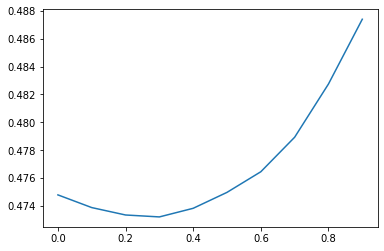

In [70]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,1,0.1),score_list)

In [67]:
best_param

{'C': 1.0, 'epsilon': 0.30000000000000004}

# eplisonを絞り込む

In [71]:
from sklearn.metrics import mean_squared_error
import joblib

score_list = []
best_score = np.inf
for i,epsilon in enumerate(np.arange(0.25,0.35,0.01)): 
    param = {
        'C': 1.0,
        'epsilon': epsilon
    }
    for fold in range(dftr.FOLD.nunique()):

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):

            modelname = OUTPUT_DIR+f'svr_{t}_fold{fold}.sav'
            clf = SVR(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds

        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)


    dftr.to_pickle(OUTPUT_DIR+f'oof_df.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)
    if score<best_score:
        print(i,score)
        best_score = score
        best_param = param

5 0.4731777575765652


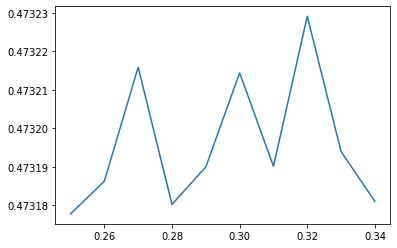

In [72]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0.25,0.35,0.01),score_list)

In [74]:
best_score,best_param

(0.4731777575765652, {'C': 1.0, 'epsilon': 0.25})

# 最終的なSVR

In [76]:
from sklearn.metrics import mean_squared_error
import joblib

param = best_param

scores = []
# for param in params:
for fold in range(dftr.FOLD.nunique()):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    
    dftr_ = dftr[dftr["FOLD"]!=fold]
    dfev_ = dftr[dftr["FOLD"]==fold]
    

    tr_text_feats = all_train_text_feats[list(dftr_.index),:]
    ev_text_feats = all_train_text_feats[list(dfev_.index),:]
    
    ev_preds = np.zeros((len(ev_text_feats),6))
    for i,t in enumerate(target_cols):
        print(t,', ',end='')
        modelname = OUTPUT_DIR+f'svr_{t}_fold{fold}.sav'
        clf = SVR(**best_param)
        clf.fit(tr_text_feats, dftr_[t].values)
        joblib.dump(clf, modelname)
        loaded_model = joblib.load(modelname)
        ev_preds[:,i] = loaded_model .predict(ev_text_feats)
        
    cols = [f"pred_{t}" for t in target_cols]
    dftr.loc[list(dfev_.index),cols] = ev_preds
    print()
    score = comp_score(dfev_[target_cols].values,ev_preds)
    scores.append(score)
    print("Fold : {} RSME score: {}".format(fold,score))

dftr.to_pickle(OUTPUT_DIR+f'oof_df.pkl')
score,scores = get_result2(dftr)
print('#'*25)
print(score)

#########################
### Fold 1
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 0 RSME score: 0.4678718604152902
#########################
### Fold 2
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 1 RSME score: 0.4775672134214997
#########################
### Fold 3
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 2 RSME score: 0.47728238304276777
#########################
### Fold 4
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 
Fold : 3 RSME score: 0.46986171984226405
#########################
0.4731777575765652


# ridge回帰

In [79]:
from sklearn.metrics import mean_squared_error
import joblib
from sklearn import linear_model

score_list = []
best_score = np.inf
alpha_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000]
for alpha in alpha_list: 
    param = {
        'alpha': alpha,
        "random_state":0
    }
    for fold in range(dftr.FOLD.nunique()):

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):

            modelname = OUTPUT_DIR+f'ridge_{t}_fold{fold}.sav'
            clf = linear_model.Ridge(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds

        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)


    dftr.to_pickle(OUTPUT_DIR+f'oof_df_ridge.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)
    if score<best_score:
        print(i,score)
        best_score = score
        best_param = param

5 0.5712472268431372
5 0.5568494565875634
5 0.5447147761316596
5 0.5089171189034098
5 0.49558964672990413
5 0.4770940638548213
5 0.47390727911997055


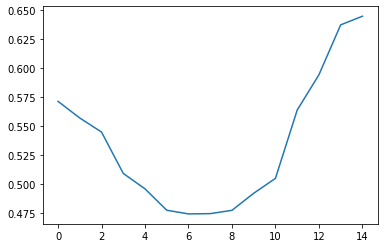

In [81]:
import matplotlib.pyplot as plt
plt.plot(score_list)

In [83]:
best_param

{'alpha': 0.1, 'random_state': 0}

In [86]:
from sklearn.metrics import mean_squared_error
import joblib
from sklearn import linear_model

score_list = []
best_score = np.inf
alpha_list = list(np.arange(0.05,0.15,0.01))
for alpha in alpha_list: 
    param = {
        'alpha': alpha,
        "random_state":0
    }
    for fold in range(dftr.FOLD.nunique()):

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):

            modelname = OUTPUT_DIR+f'ridge_{t}_fold{fold}.sav'
            clf = linear_model.Ridge(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds

        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)


    dftr.to_pickle(OUTPUT_DIR+f'oof_df_ridge.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)
    if score<best_score:
        print(i,score)
        best_score = score
        best_param = param

5 0.4770940638548213
5 0.476020187143912
5 0.47524861008195957
5 0.4746761292793396
5 0.47424183608009557
5 0.47390727911997055
5 0.47364702703713224
5 0.473443506987626
5 0.47328421635609236
5 0.4731600320639669


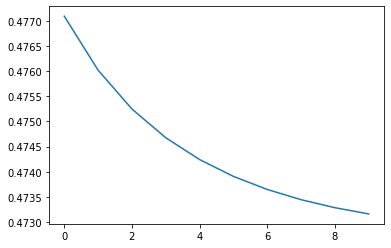

In [87]:
import matplotlib.pyplot as plt
plt.plot(score_list)

In [88]:
best_param

{'alpha': 0.14, 'random_state': 0}

In [89]:
from sklearn.metrics import mean_squared_error
import joblib
from sklearn import linear_model

score_list = []
best_score = np.inf
alpha_list = list(np.arange(0.14,0.4,0.01))
for alpha in alpha_list: 
    param = {
        'alpha': alpha,
        "random_state":0
    }
    for fold in range(dftr.FOLD.nunique()):

        dftr_ = dftr[dftr["FOLD"]!=fold]
        dfev_ = dftr[dftr["FOLD"]==fold]


        tr_text_feats = all_train_text_feats[list(dftr_.index),:]
        ev_text_feats = all_train_text_feats[list(dfev_.index),:]

        ev_preds = np.zeros((len(ev_text_feats),6))
        for i,t in enumerate(target_cols):

            modelname = OUTPUT_DIR+f'ridge_{t}_fold{fold}.sav'
            clf = linear_model.Ridge(**param)
            clf.fit(tr_text_feats, dftr_[t].values)
            joblib.dump(clf, modelname)
            loaded_model = joblib.load(modelname)
            ev_preds[:,i] = loaded_model .predict(ev_text_feats)

        cols = [f"pred_{t}" for t in target_cols]
        dftr.loc[list(dfev_.index),cols] = ev_preds

        score = comp_score(dfev_[target_cols].values,ev_preds)
        scores.append(score)


    dftr.to_pickle(OUTPUT_DIR+f'oof_df_ridge.pkl')
    score,scores = get_result2(dftr)
    score_list.append(score)
    if score<best_score:
        print(i,score)
        best_score = score
        best_param = param

5 0.4731600320639669
5 0.47306409329033733
5 0.47299118000981083
5 0.47293727402450686
5 0.472899155403246
5 0.4728743067409942
5 0.47286066556456396
5 0.47285657009865756


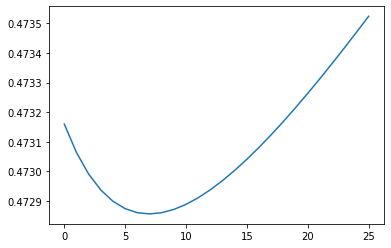

In [90]:
import matplotlib.pyplot as plt
plt.plot(score_list)

In [91]:
best_param

{'alpha': 0.21000000000000008, 'random_state': 0}

# ridge回帰　パラメーター方針を変える

In [102]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import joblib


alpha_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000]
pred_cols2 = []
for t in CFG.target_cols:
    files_path = []
    best_score = np.inf
    best_alpha = np.nan
    for alpha in alpha_list:
        for fold in range(dftr.FOLD.nunique()):    
            dftr_ = dftr[dftr["FOLD"]!=fold]
            dfev_ = dftr[dftr["FOLD"]==fold]

            tr_text_feats = all_train_text_feats[list(dftr_.index),:]
            ev_text_feats = all_train_text_feats[list(dfev_.index),:]

            clf = linear_model.Ridge(alpha=alpha,random_state=0)
            clf.fit(tr_text_feats, dftr_[t].values)
            
            filename = OUTPUT_DIR+f'ridge_{t}_fold{fold}_alpha{alpha}.sav'
            files_path.append(filename)
            pickle.dump(clf, open(filename, 'wb'))
            
            preds = clf.predict(ev_text_feats)
            preds = np.clip(preds,1,5)
            dftr.loc[dftr["FOLD"]==fold,f"{t}_preds_ridge_alpha{alpha}"] = preds

        score = np.sqrt(mean_squared_error(dftr[f"{t}_preds_ridge_alpha{alpha}"].to_numpy()\
                                  ,dftr[t].to_numpy()))

        if score < best_score:
            best_score = score
            best_alpha = alpha
            #print(f"best_score:alpha_{alpha}",score)
            
    drop_files = [s for s in files_path if s not in \
              [OUTPUT_DIR+f'ridge_{t}_fold{fold}_alpha{best_alpha}.sav'\
               for fold in range(dftr.FOLD.nunique())]]
    pred_cols2.append(f"{t}_preds_ridge_alpha{best_alpha}")
    for file in drop_files:
        os.remove(file)

In [105]:
score, scores = get_score(dftr[pred_cols2].to_numpy(), dftr[CFG.target_cols].to_numpy())
print(score)

0.4732015416503437


In [106]:
pred_cols2

['cohesion_preds_ridge_alpha0.1',
 'syntax_preds_ridge_alpha0.1',
 'vocabulary_preds_ridge_alpha0.1',
 'phraseology_preds_ridge_alpha0.5',
 'grammar_preds_ridge_alpha0.5',
 'conventions_preds_ridge_alpha0.5']

# alphaを絞る

In [109]:
list(np.arange(0.05,1.0,0.05))

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.6500000000000001,
 0.7000000000000001,
 0.7500000000000001,
 0.8,
 0.8500000000000001,
 0.9000000000000001,
 0.9500000000000001]

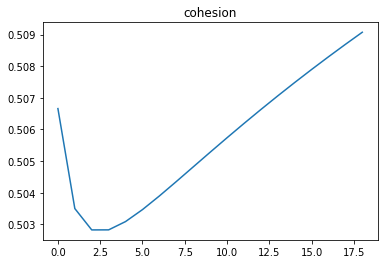

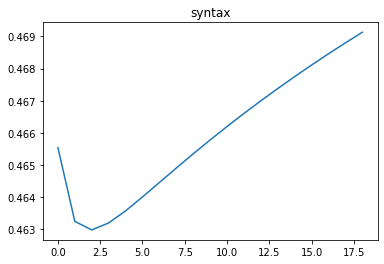

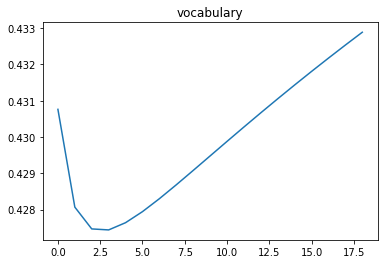

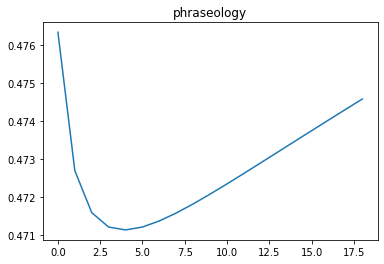

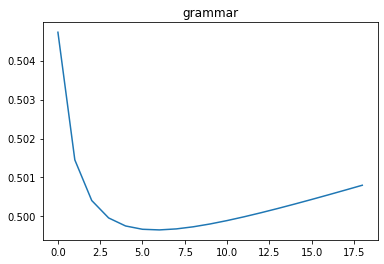

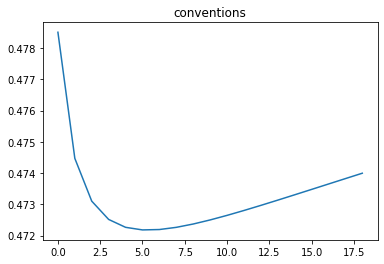

0.4727046113744207


In [126]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import joblib


alpha_list = list(np.arange(0.05,1.0,0.05))
pred_cols2 = []
for t in CFG.target_cols:
    files_path = []
    best_score = np.inf
    best_alpha = np.nan
    _ = []
    for alpha in alpha_list:
        for fold in range(dftr.FOLD.nunique()):    
            dftr_ = dftr[dftr["FOLD"]!=fold]
            dfev_ = dftr[dftr["FOLD"]==fold]

            tr_text_feats = all_train_text_feats[list(dftr_.index),:]
            ev_text_feats = all_train_text_feats[list(dfev_.index),:]

            clf = linear_model.Ridge(alpha=alpha,random_state=0)
            clf.fit(tr_text_feats, dftr_[t].values)
            
            filename = OUTPUT_DIR+f'ridge_{t}_fold{fold}_alpha{alpha}.sav'
            files_path.append(filename)
            pickle.dump(clf, open(filename, 'wb'))
            
            preds = clf.predict(ev_text_feats)
            preds = np.clip(preds,1,5)
            dftr.loc[dftr["FOLD"]==fold,f"{t}_preds_ridge_alpha{alpha}"] = preds

        score = np.sqrt(mean_squared_error(dftr[f"{t}_preds_ridge_alpha{alpha}"].to_numpy()\
                                  ,dftr[t].to_numpy()))
        _.append(score)

        if score < best_score:
            best_score = score
            best_alpha = alpha
            #print(f"best_score:alpha_{alpha}",score)
            
    fig = plt.figure()
    plt.plot(_)
    plt.title(t)
    plt.show()
            
    drop_files = [s for s in files_path if s not in \
              [OUTPUT_DIR+f'ridge_{t}_fold{fold}_alpha{best_alpha}.sav'\
               for fold in range(dftr.FOLD.nunique())]]
    pred_cols2.append(f"{t}_preds_ridge_alpha{best_alpha}")
    for file in drop_files:
        os.remove(file)
        
score, scores = get_score(dftr[pred_cols2].to_numpy(), dftr[CFG.target_cols].to_numpy())
print(score)

In [127]:
pred_cols2

['cohesion_preds_ridge_alpha0.15000000000000002',
 'syntax_preds_ridge_alpha0.15000000000000002',
 'vocabulary_preds_ridge_alpha0.2',
 'phraseology_preds_ridge_alpha0.25',
 'grammar_preds_ridge_alpha0.35000000000000003',
 'conventions_preds_ridge_alpha0.3']

In [128]:
pred_ridge = pred_cols2

In [129]:
dftr[["text_id","FOLD"]+pred_ridge+CFG.target_cols].to_pickle(OUTPUT_DIR+"oof_df_ridge.pkl")
s = pd.read_pickle(OUTPUT_DIR+"oof_df_ridge.pkl").rename(columns={"FOLD":"fold"})
s[["text_id","fold"]+pred_ridge+CFG.target_cols].to_pickle(OUTPUT_DIR+"oof_df_ridge.pkl")

In [121]:
OUTPUT_DIR

'/home/jupyter/output/ex/bert-large-uncased/002/202211092216/'

# lasso回帰

In [137]:
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions',]

dftr = pd.read_csv("/home/jupyter/feedback-prize-english-language-learning/train.csv")
dftr["src"]="train"
dfte = pd.read_csv("/home/jupyter/feedback-prize-english-language-learning/test.csv")
dfte["src"]="test"
print('Train shape:',dftr.shape,'Test shape:',dfte.shape,'Test columns:',dfte.columns)
df = pd.concat([dftr,dfte],ignore_index=True)

fold = np.load("/home/jupyter/output/fold/4fold.npy")

dftr["fold"] = fold
if CFG.DEBUG:
    dftr = dftr.head(20)
    
all_train_text_feats = np.load(OUTPUT_DIR+"train_embedding.npy")
if CFG.DEBUG:
    all_train_text_feats = all_train_text_feats[:20]

Train shape: (3911, 9) Test shape: (3, 3) Test columns: Index(['text_id', 'full_text', 'src'], dtype='object')


In [138]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import joblib


alpha_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000]
pred_cols2 = []
for t in CFG.target_cols:
    files_path = []
    best_score = np.inf
    best_alpha = np.nan
    for alpha in alpha_list:
        for fold in range(dftr.fold.nunique()):    
            dftr_ = dftr[dftr["fold"]!=fold]
            dfev_ = dftr[dftr["fold"]==fold]

            tr_text_feats = all_train_text_feats[list(dftr_.index),:]
            ev_text_feats = all_train_text_feats[list(dfev_.index),:]

            clf = linear_model.Lasso(alpha=alpha,random_state=0)
            clf.fit(tr_text_feats, dftr_[t].values)
            
            # filename = OUTPUT_DIR+f'lasso_{t}_fold{fold}_alpha{alpha}.sav'
            # files_path.append(filename)
            # pickle.dump(clf, open(filename, 'wb'))
            
            preds = clf.predict(ev_text_feats)
            preds = np.clip(preds,1,5)
            dftr.loc[dftr["fold"]==fold,f"{t}_preds_lasso_alpha{alpha}"] = preds

        score = np.sqrt(mean_squared_error(dftr[f"{t}_preds_lasso_alpha{alpha}"].to_numpy()\
                                  ,dftr[t].to_numpy()))

        if score < best_score:
            best_score = score
            best_alpha = alpha
            #print(f"best_score:alpha_{alpha}",score)
            
    pred_cols2.append(f"{t}_preds_lasso_alpha{best_alpha}")
    # for file in files_path:
    #     os.remove(file)
    
score, scores = get_score(dftr[pred_cols2].to_numpy(), dftr[CFG.target_cols].to_numpy())
print(score)

0.4781470159698391


In [139]:
pred_cols2

['cohesion_preds_lasso_alpha0.0001',
 'syntax_preds_lasso_alpha0.0001',
 'vocabulary_preds_lasso_alpha0.0001',
 'phraseology_preds_lasso_alpha0.0001',
 'grammar_preds_lasso_alpha0.0001',
 'conventions_preds_lasso_alpha0.0001']

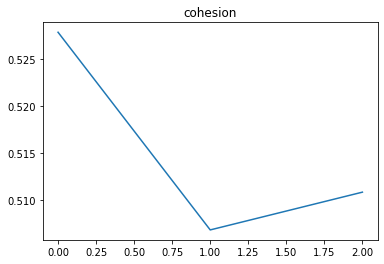

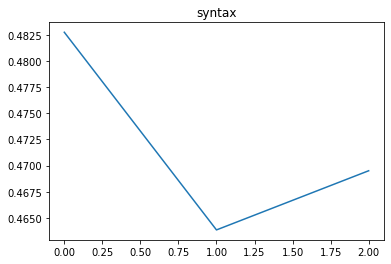

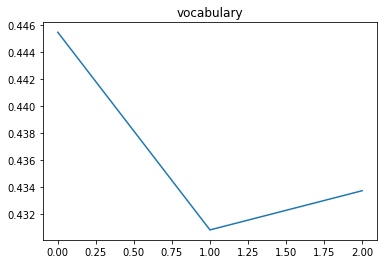

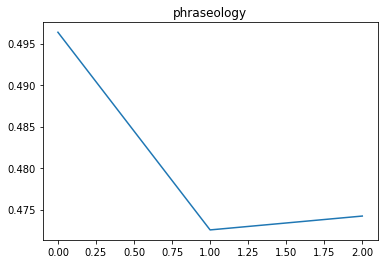

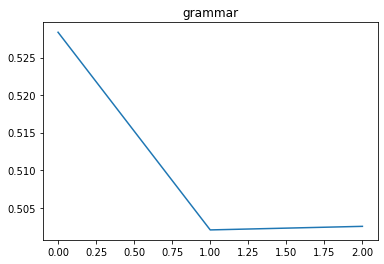

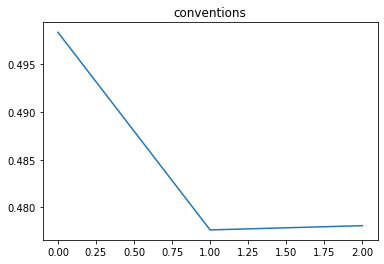

0.4756157320085593


In [140]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import joblib


alpha_list = [0.00001, 0.00005,0.0001]
pred_cols2 = []
for t in CFG.target_cols:
    files_path = []
    best_score = np.inf
    best_alpha = np.nan
    _ = []
    for alpha in alpha_list:
        for fold in range(dftr.fold.nunique()):    
            dftr_ = dftr[dftr["fold"]!=fold]
            dfev_ = dftr[dftr["fold"]==fold]

            tr_text_feats = all_train_text_feats[list(dftr_.index),:]
            ev_text_feats = all_train_text_feats[list(dfev_.index),:]

            clf = linear_model.Lasso(alpha=alpha,random_state=0)
            clf.fit(tr_text_feats, dftr_[t].values)
            
            # filename = OUTPUT_DIR+f'lasso_{t}_fold{fold}_alpha{alpha}.sav'
            # files_path.append(filename)
            # pickle.dump(clf, open(filename, 'wb'))
            
            preds = clf.predict(ev_text_feats)
            preds = np.clip(preds,1,5)
            dftr.loc[dftr["fold"]==fold,f"{t}_preds_lasso_alpha{alpha}"] = preds

        score = np.sqrt(mean_squared_error(dftr[f"{t}_preds_lasso_alpha{alpha}"].to_numpy()\
                                  ,dftr[t].to_numpy()))
        _.append(score)
        if score < best_score:
            best_score = score
            best_alpha = alpha
            #print(f"best_score:alpha_{alpha}",score)
            
    fig = plt.figure()
    plt.plot(_)
    plt.title(t)
    plt.show()
            
    pred_cols2.append(f"{t}_preds_lasso_alpha{best_alpha}")
    # for file in files_path:
    #     os.remove(file)
    
score, scores = get_score(dftr[pred_cols2].to_numpy(), dftr[CFG.target_cols].to_numpy())
print(score)

In [141]:
pred_cols2

['cohesion_preds_lasso_alpha5e-05',
 'syntax_preds_lasso_alpha5e-05',
 'vocabulary_preds_lasso_alpha5e-05',
 'phraseology_preds_lasso_alpha5e-05',
 'grammar_preds_lasso_alpha5e-05',
 'conventions_preds_lasso_alpha5e-05']

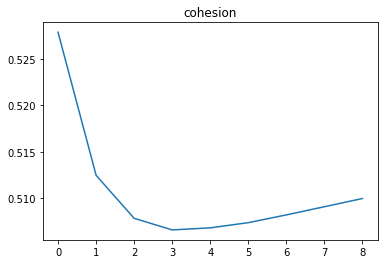

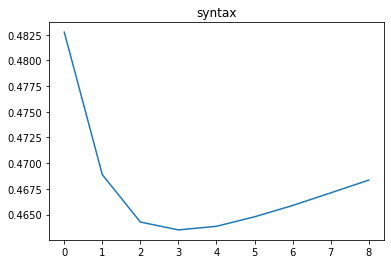

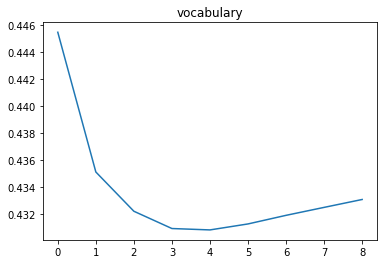

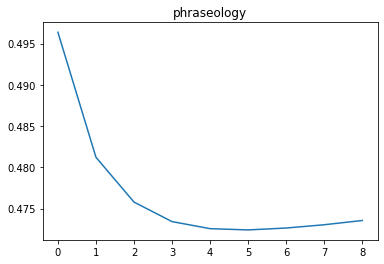

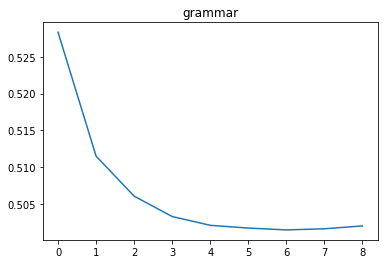

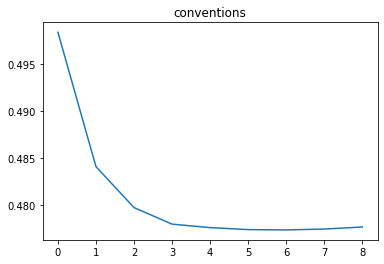

0.4753492491641018


In [143]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import joblib


alpha_list = list(np.arange(0.00001,0.0001,0.00001))
pred_cols2 = []
for t in CFG.target_cols:
    files_path = []
    best_score = np.inf
    best_alpha = np.nan
    _ = []
    for alpha in alpha_list:
        for fold in range(dftr.fold.nunique()):    
            dftr_ = dftr[dftr["fold"]!=fold]
            dfev_ = dftr[dftr["fold"]==fold]

            tr_text_feats = all_train_text_feats[list(dftr_.index),:]
            ev_text_feats = all_train_text_feats[list(dfev_.index),:]

            clf = linear_model.Lasso(alpha=alpha,random_state=0)
            clf.fit(tr_text_feats, dftr_[t].values)
            
            filename = OUTPUT_DIR+f'lasso_{t}_fold{fold}_alpha{alpha}.sav'
            files_path.append(filename)
            pickle.dump(clf, open(filename, 'wb'))
            
            preds = clf.predict(ev_text_feats)
            preds = np.clip(preds,1,5)
            dftr.loc[dftr["fold"]==fold,f"{t}_preds_lasso_alpha{alpha}"] = preds

        score = np.sqrt(mean_squared_error(dftr[f"{t}_preds_lasso_alpha{alpha}"].to_numpy()\
                                  ,dftr[t].to_numpy()))
        _.append(score)
        if score < best_score:
            best_score = score
            best_alpha = alpha
            #print(f"best_score:alpha_{alpha}",score)
            
    fig = plt.figure()
    plt.plot(_)
    plt.title(t)
    plt.show()
            
    drop_files = [s for s in files_path if s not in \
              [OUTPUT_DIR+f'lasso_{t}_fold{fold}_alpha{best_alpha}.sav'\
               for fold in range(dftr.fold.nunique())]]
    pred_cols2.append(f"{t}_preds_lasso_alpha{best_alpha}")
    for file in drop_files:
        os.remove(file)
    
score, scores = get_score(dftr[pred_cols2].to_numpy(), dftr[CFG.target_cols].to_numpy())
print(score)

In [144]:
pred_lasso = pred_cols2
dftr[["text_id","fold"]+pred_lasso+CFG.target_cols].to_pickle(OUTPUT_DIR+"oof_df_lasso.pkl")

# kaggle

In [145]:
CFG.TO_KAGGLE = True

In [146]:
if CFG.TO_KAGGLE:
    UPLOAD_DIR = OUTPUT_DIR
    EX_NO = f"{model_name}-{CFG.file_name}" # 実験番号などを入れる、folderのpathにする
    USERID = 'your_id'


    def dataset_upload():
        import json
        from kaggle.api.kaggle_api_extended import KaggleApi

        id = f'{USERID}/{EX_NO}'

        dataset_metadata = {}
        dataset_metadata['id'] = id
        dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
        dataset_metadata['title'] = f'{EX_NO}'

        with open(UPLOAD_DIR +'dataset-metadata.json', 'w') as f:
            json.dump(dataset_metadata, f, indent=4)

        api = KaggleApi()
        api.authenticate()

        # データセットがない場合
        if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
            api.dataset_create_new(folder=UPLOAD_DIR,
                                   convert_to_csv=False,
                                   dir_mode='skip')

             #フォルダーを削除
            if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
                print("folder upload")
            else:
                print("folder not upload")

        # データセットがある場合→更新されない場合がある（後で原因追及)
        else:
            print("this folder exsits")
    dataset_upload()

Starting upload for file ridge_phraseology_fold3_alpha0.25.sav


100% 4.60k/4.60k [00:02<00:00, 1.84kB/s]


Upload successful: ridge_phraseology_fold3_alpha0.25.sav (5KB)
Starting upload for file ridge_conventions_fold0_alpha0.3.sav


100% 4.60k/4.60k [00:02<00:00, 2.03kB/s]


Upload successful: ridge_conventions_fold0_alpha0.3.sav (5KB)
Starting upload for file lasso_cohesion_fold2_alpha4e-05.sav


100% 4.69k/4.69k [00:03<00:00, 1.57kB/s]


Upload successful: lasso_cohesion_fold2_alpha4e-05.sav (5KB)
Starting upload for file lasso_phraseology_fold0_alpha6e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.98kB/s]


Upload successful: lasso_phraseology_fold0_alpha6e-05.sav (5KB)
Starting upload for file ridge_phraseology_fold2_alpha0.25.sav


100% 4.60k/4.60k [00:02<00:00, 1.82kB/s]


Upload successful: ridge_phraseology_fold2_alpha0.25.sav (5KB)
Starting upload for file ridge_conventions_fold1_alpha0.3.sav


100% 4.60k/4.60k [00:02<00:00, 2.29kB/s]


Upload successful: ridge_conventions_fold1_alpha0.3.sav (5KB)
Starting upload for file ridge_conventions_fold2_alpha0.3.sav


100% 4.60k/4.60k [00:02<00:00, 2.22kB/s]


Upload successful: ridge_conventions_fold2_alpha0.3.sav (5KB)
Starting upload for file lasso_vocabulary_fold0_alpha5e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.97kB/s]


Upload successful: lasso_vocabulary_fold0_alpha5e-05.sav (5KB)
Starting upload for file ridge_cohesion_fold1_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.64kB/s]


Upload successful: ridge_cohesion_fold1_alpha0.15000000000000002.sav (5KB)
Starting upload for file lasso_conventions_fold2_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.76kB/s]


Upload successful: lasso_conventions_fold2_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_grammar_fold0_alpha0.35000000000000003.sav


100% 4.60k/4.60k [00:02<00:00, 1.70kB/s]


Upload successful: ridge_grammar_fold0_alpha0.35000000000000003.sav (5KB)
Starting upload for file train_embedding.npy


100% 15.3M/15.3M [00:03<00:00, 4.48MB/s]


Upload successful: train_embedding.npy (15MB)
Starting upload for file ridge_grammar_fold2_alpha0.35000000000000003.sav


100% 4.60k/4.60k [00:03<00:00, 1.57kB/s]


Upload successful: ridge_grammar_fold2_alpha0.35000000000000003.sav (5KB)
Starting upload for file lasso_phraseology_fold3_alpha6e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.75kB/s]


Upload successful: lasso_phraseology_fold3_alpha6e-05.sav (5KB)
Starting upload for file ridge_vocabulary_fold0_alpha0.2.sav


100% 4.60k/4.60k [00:02<00:00, 1.64kB/s]


Upload successful: ridge_vocabulary_fold0_alpha0.2.sav (5KB)
Starting upload for file lasso_conventions_fold0_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.65kB/s]


Upload successful: lasso_conventions_fold0_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_phraseology_fold0_alpha0.25.sav


100% 4.60k/4.60k [00:02<00:00, 1.72kB/s]


Upload successful: ridge_phraseology_fold0_alpha0.25.sav (5KB)
Starting upload for file lasso_grammar_fold0_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:03<00:00, 1.51kB/s]


Upload successful: lasso_grammar_fold0_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_syntax_fold2_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.79kB/s]


Upload successful: ridge_syntax_fold2_alpha0.15000000000000002.sav (5KB)
Starting upload for file lasso_vocabulary_fold2_alpha5e-05.sav


100% 4.69k/4.69k [00:02<00:00, 2.32kB/s]


Upload successful: lasso_vocabulary_fold2_alpha5e-05.sav (5KB)
Starting upload for file lasso_grammar_fold1_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.69kB/s]


Upload successful: lasso_grammar_fold1_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_vocabulary_fold3_alpha0.2.sav


100% 4.60k/4.60k [00:02<00:00, 1.69kB/s]


Upload successful: ridge_vocabulary_fold3_alpha0.2.sav (5KB)
Starting upload for file lasso_grammar_fold3_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.75kB/s]


Upload successful: lasso_grammar_fold3_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_syntax_fold1_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.75kB/s]


Upload successful: ridge_syntax_fold1_alpha0.15000000000000002.sav (5KB)
Starting upload for file lasso_cohesion_fold3_alpha4e-05.sav


100% 4.69k/4.69k [00:02<00:00, 2.13kB/s]


Upload successful: lasso_cohesion_fold3_alpha4e-05.sav (5KB)
Starting upload for file ridge_phraseology_fold1_alpha0.25.sav


100% 4.60k/4.60k [00:02<00:00, 1.78kB/s]


Upload successful: ridge_phraseology_fold1_alpha0.25.sav (5KB)
Starting upload for file ridge_cohesion_fold3_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.87kB/s]


Upload successful: ridge_cohesion_fold3_alpha0.15000000000000002.sav (5KB)
Starting upload for file ridge_vocabulary_fold1_alpha0.2.sav


100% 4.60k/4.60k [00:02<00:00, 1.89kB/s]


Upload successful: ridge_vocabulary_fold1_alpha0.2.sav (5KB)
Starting upload for file lasso_vocabulary_fold3_alpha5e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.82kB/s]


Upload successful: lasso_vocabulary_fold3_alpha5e-05.sav (5KB)
Starting upload for file lasso_syntax_fold0_alpha4e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.73kB/s]


Upload successful: lasso_syntax_fold0_alpha4e-05.sav (5KB)
Starting upload for file lasso_conventions_fold1_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.73kB/s]


Upload successful: lasso_conventions_fold1_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file lasso_cohesion_fold1_alpha4e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.68kB/s]


Upload successful: lasso_cohesion_fold1_alpha4e-05.sav (5KB)
Starting upload for file lasso_phraseology_fold1_alpha6e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.95kB/s]


Upload successful: lasso_phraseology_fold1_alpha6e-05.sav (5KB)
Starting upload for file ridge_cohesion_fold0_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.93kB/s]


Upload successful: ridge_cohesion_fold0_alpha0.15000000000000002.sav (5KB)
Starting upload for file lasso_grammar_fold2_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.61kB/s]


Upload successful: lasso_grammar_fold2_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_cohesion_fold2_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.76kB/s]


Upload successful: ridge_cohesion_fold2_alpha0.15000000000000002.sav (5KB)
Starting upload for file lasso_syntax_fold2_alpha4e-05.sav


100% 4.69k/4.69k [00:03<00:00, 1.59kB/s]


Upload successful: lasso_syntax_fold2_alpha4e-05.sav (5KB)
Starting upload for file ridge_syntax_fold3_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 2.31kB/s]


Upload successful: ridge_syntax_fold3_alpha0.15000000000000002.sav (5KB)
Starting upload for file ridge_grammar_fold1_alpha0.35000000000000003.sav


100% 4.60k/4.60k [00:02<00:00, 1.60kB/s]


Upload successful: ridge_grammar_fold1_alpha0.35000000000000003.sav (5KB)
Starting upload for file lasso_syntax_fold1_alpha4e-05.sav


100% 4.69k/4.69k [00:01<00:00, 2.46kB/s]


Upload successful: lasso_syntax_fold1_alpha4e-05.sav (5KB)
Starting upload for file oof_df_lasso.pkl


100% 364k/364k [00:02<00:00, 163kB/s]


Upload successful: oof_df_lasso.pkl (364KB)
Starting upload for file lasso_conventions_fold3_alpha7.000000000000001e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.86kB/s]


Upload successful: lasso_conventions_fold3_alpha7.000000000000001e-05.sav (5KB)
Starting upload for file ridge_conventions_fold3_alpha0.3.sav


100% 4.60k/4.60k [00:02<00:00, 2.05kB/s]


Upload successful: ridge_conventions_fold3_alpha0.3.sav (5KB)
Starting upload for file oof_df_ridge.pkl


100% 364k/364k [00:02<00:00, 126kB/s]


Upload successful: oof_df_ridge.pkl (364KB)
Starting upload for file lasso_cohesion_fold0_alpha4e-05.sav


100% 4.69k/4.69k [00:03<00:00, 1.58kB/s]


Upload successful: lasso_cohesion_fold0_alpha4e-05.sav (5KB)
Starting upload for file ridge_grammar_fold3_alpha0.35000000000000003.sav


100% 4.60k/4.60k [00:02<00:00, 1.94kB/s]


Upload successful: ridge_grammar_fold3_alpha0.35000000000000003.sav (5KB)
Starting upload for file lasso_syntax_fold3_alpha4e-05.sav


100% 4.69k/4.69k [00:02<00:00, 2.11kB/s]


Upload successful: lasso_syntax_fold3_alpha4e-05.sav (5KB)
Starting upload for file lasso_vocabulary_fold1_alpha5e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.75kB/s]


Upload successful: lasso_vocabulary_fold1_alpha5e-05.sav (5KB)
Starting upload for file lasso_phraseology_fold2_alpha6e-05.sav


100% 4.69k/4.69k [00:02<00:00, 1.79kB/s]


Upload successful: lasso_phraseology_fold2_alpha6e-05.sav (5KB)
Starting upload for file ridge_syntax_fold0_alpha0.15000000000000002.sav


100% 4.60k/4.60k [00:02<00:00, 1.95kB/s]


Upload successful: ridge_syntax_fold0_alpha0.15000000000000002.sav (5KB)
Starting upload for file ridge_vocabulary_fold2_alpha0.2.sav


100% 4.60k/4.60k [00:02<00:00, 2.09kB/s]


Upload successful: ridge_vocabulary_fold2_alpha0.2.sav (5KB)
folder upload


In [156]:
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def to_write_score(CFG,oof_df):
    df = pd.read_csv(CFG.score_path)
    def get_result2(oof_df):
            labels = oof_df[CFG.target_cols].values
            preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
            score, scores = get_score(labels, preds)
            LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
            return score,scores

    score,scores = get_result2(oof_df)
    name = "-".join(OUTPUT_DIR.split("/")[-4:-2])
    base = {"name":name,"score":score,"memo":CFG.MEMO} 
    base.update(dict(zip(CFG.target_cols,scores)))
    df = df.append(base,ignore_index=True)
    df.to_csv(CFG.score_path,index=False)


In [157]:
oof_df = pd.read_pickle(OUTPUT_DIR+"oof_df_lasso.pkl")
CFG.MEMO = "lasso"

re_cols = ['pred_cohesion', 'pred_syntax', 'pred_vocabulary', 'pred_phraseology'\
           ,'pred_grammar', 'pred_conventions']
cols = oof_df.columns[2:8]
oof_df = oof_df.rename(columns=dict(zip(cols,re_cols)))

to_write_score(CFG,oof_df)

Score: 0.4753  Scores: [0.5065573069108552, 0.46350985113309506, 0.43079235499710083, 0.4724036347754674, 0.5014239960458493, 0.4774083511222429]


In [159]:
oof_df = pd.read_pickle(OUTPUT_DIR+"oof_df_ridge.pkl")
CFG.MEMO = "ridge"

re_cols = ['pred_cohesion', 'pred_syntax', 'pred_vocabulary', 'pred_phraseology'\
           ,'pred_grammar', 'pred_conventions']
cols = oof_df.columns[2:8]
oof_df = oof_df.rename(columns=dict(zip(cols,re_cols)))

to_write_score(CFG,oof_df)

Score: 0.4727  Scores: [0.502826906352543, 0.4629854207439849, 0.4274383491507307, 0.4711436095050198, 0.4996538762757504, 0.47217950621849514]


In [160]:
df = pd.read_csv(CFG.score_path)
df

,name,memo,LB,score,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,base-discriminator-001,NaN,0.46,0.466957,0.501431,0.455460,0.428477,0.465690,0.485904,0.464780
1,base-discriminator-002,NaN,0.45,0.474078,0.504413,0.462707,0.432588,0.469546,0.500918,0.474296
2,deberta-v3-base-003,2epochs,NaN,0.459342,0.496531,0.450482,0.419448,0.457413,0.476347,0.455832
3,deberta-v3-base-003,6epochs,0.44,0.456879,0.488333,0.448687,0.417134,0.458769,0.479633,0.448721
4,deberta-v3-base-006,15folds,NaN,0.463635,0.479650,0.475910,0.442828,0.463557,0.456412,0.463457
5,deberta-v3-base-006,20folds,NaN,0.449212,0.475585,0.433808,0.415852,0.457436,0.484686,0.427907
6,deberta-v3-base-006,10folds,NaN,0.446338,0.490661,0.435001,0.409460,0.417236,0.481800,0.443871
7,distilroberta-base-001,4folds,NaN,0.470528,0.501629,0.459765,0.426740,0.473205,0.501976,0.459850
8,distilroberta-base-002,"バッチ16,4folds",NaN,0.471035,0.503345,0.458993,0.427209,0.471235,0.504850,0.460580
9,microsoft-deberta-v3-large-001,NaN,0.46,0.450311,0.482961,0.445596,0.410873,0.449346,0.466162,0.446928


In [ ]:
# !pip install transformers
# !pip install tokenizers

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
import shutil
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

os.system('pip install iterative-stratification==0.1.7')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=/home/jupyter/code_baseline/FB3_pip_wheels transformers')
os.system('python -m pip install --no-index --find-links=/home/jupyter/code_baseline/FB3_pip_wheels tokenizers')
import tokenizers
import transformers
# print(f"tokenizers.__version__: {tokenizers.__version__}")
# print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================

train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

Fold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)

if CFG.DEBUG:
    # display(train.groupby('fold').size())
    train = train.sample(n=50, random_state=0).reset_index(drop=True)
    # display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer models/roberta/roberta-base/config.json
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(f"/home/jupyter/models/{CFG.model}/")
CFG.tokenizer = tokenizer

# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
# lengths = []
# tk0 = tqdm(train['full_text'].fillna("").values, total=len(train))
# for text in tk0:
#     length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
#     lengths.append(length)
# CFG.max_len = max(lengths) + 3 # cls & sep & sep
# LOGGER.info(f"max_len: {CFG.max_len}")

In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
#MeanPoolingはoutput_hidden_statesに関係している   https://qiita.com/niship2/items/f84751aed893da869cec
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model_config_path, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model_bin_path, config=self.config)
        else:
            self.model = AutoModel(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 6)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

In [ ]:
# model_config_path = f"/home/jupyter/models/deberta/{model}/model"
# model_bin_path = f"/home/jupyter/models/deberta/{CFG.model}/model"

In [ ]:
# conf = AutoConfig.from_pretrained(f"/home/jupyter/models/deberta/{CFG.model}/model", output_hidden_states=True)
# AutoModel.from_pretrained(f"/home/jupyter/models/deberta/{CFG.model}/model", config=conf)

# Loss

In [ ]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# train loop

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.SmoothL1Loss(reduction='mean') # RMSELoss(reduction="mean")
    
    best_score = np.inf
    patience = CFG.patience
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score, scores = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {scores}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            patience = CFG.patience
        else:
            patience -= 1
            if patience<=0:
                break

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
        return score
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                score = get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        score = round(get_result(oof_df),3)
        oof_df.to_pickle(OUTPUT_DIR+f'oof_df.pkl')
        
    # if CFG.DEBUG:
    #     import send2trash
    #     send2trash.send2trash(OUTPUT_DIR)
    CFG.OUTPUT_DIR = OUTPUT_DIR
    dict_cfg = {k: vars(CFG)[k] for k in vars(CFG) if "__" not in k}
    with open(OUTPUT_DIR+"dict_cfg", 'wb') as web:
        pickle.dump(dict_cfg , web)
    with open(OUTPUT_DIR+"class_cfg", 'wb') as web:
        pickle.dump(CFG , web)
    
    
    if CFG.wandb:
        wandb.config.update(class2dict(CFG))
        wandb.finish()

In [ ]:
print(OUTPUT_DIR)

In [ ]:
# import os
# OUTPUT_DIR = "/home/jupyter/output/ex/roberta-base/004/202210151736/"
# PREDICT_DIR = OUTPUT_DIR.replace("output","predict")
# if not os.path.exists(PREDICT_DIR):
#     os.makedirs(PREDICT_DIR)


In [ ]:
if CFG.TO_KAGGLE:
    UPLOAD_DIR = OUTPUT_DIR
    EX_NO = f"{model_name}-{CFG.file_name}" # 実験番号などを入れる、folderのpathにする
    USERID = 'your_id'


    def dataset_upload():
        import json
        from kaggle.api.kaggle_api_extended import KaggleApi

        id = f'{USERID}/{EX_NO}'

        dataset_metadata = {}
        dataset_metadata['id'] = id
        dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
        dataset_metadata['title'] = f'{EX_NO}'

        with open(UPLOAD_DIR +'dataset-metadata.json', 'w') as f:
            json.dump(dataset_metadata, f, indent=4)

        api = KaggleApi()
        api.authenticate()

        # データセットがない場合
        if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
            api.dataset_create_new(folder=UPLOAD_DIR,
                                   convert_to_csv=False,
                                   dir_mode='skip')
            
            
             #フォルダーを削除
            if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
                remove_files = glob.glob(OUTPUT_DIR+"*")
                remove_files.remove(OUTPUT_DIR+"oof_df.pkl")
                for file in remove_files:
                    os.remove(file)
                print("folder upload")
                            #apiコマンドを書き込む
                f = open(f'{model_name}_api_command.txt', 'a')
                api_command = f"!kaggle datasets download -d hiroki8383/{EX_NO}\n"
                f.write(api_command)
                f.close()
            else:
                print("folder not upload")
            
            
        # データセットがある場合→更新されない場合がある（後で原因追及)
        else:
            print("this folder exsits")
            # api.dataset_create_version(folder=UPLOAD_DIR,
            #                            version_notes='update',
            #                            convert_to_csv=False,
            #                            delete_old_versions=False,
            #                            dir_mode='zip')

        

        
    dataset_upload()

In [ ]:
if not CFG.DEBUG:
    def to_write_score(CFG):
        df = pd.read_csv(CFG.score_path)
        def get_result2(oof_df):
                labels = oof_df[CFG.target_cols].values
                preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
                score, scores = get_score(labels, preds)
                LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
                return score,scores

        score,scores = get_result2(oof_df)
        name = "-".join(OUTPUT_DIR.split("/")[-4:-2])
        base = {"name":name,"score":score,"memo":CFG.MEMO} 
        base.update(dict(zip(CFG.target_cols,scores)))
        df = df.append(base,ignore_index=True)
        df.to_csv(CFG.score_path,index=False)
    to_write_score(CFG)

In [ ]:
df = pd.read_csv(CFG.score_path)
df